<h1>Data setup</h1>
<h2>Use our function to read the data file</h2>

In [1]:
def read_311_data(datafile):
    import pandas as pd
    import numpy as np
    
    #Add the fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 19999:
            return np.NaN
        return str(input_zip)
    
    #Read the file
    df = pd.read_csv(datafile, index_col='Unique Key')
    
    #fix the zip
    df['Incident Zip'] = df['Incident Zip'].apply(fix_zip)
    
    #drop all rows that have any nans in them (note the easier syntax!)
    
    df = df.dropna(how='any')
    
    #get rid of unspecified boroughs
    df = df[df['Borough'] != 'Unspecified']
    
    #Convert times to datetime and create a processing time column
    
    import datetime
    df['Created Date'] = df['Created Date'].apply(lambda x: datetime.
                                                  datetime.
                                                  strptime(x,'%m/%d/%Y %H:%M'))
    df['Closed Date'] = df['Closed Date'].apply(lambda x: datetime.
                                                datetime.
                                                strptime(x,'%m/%d/%Y %H:%M'))
    df['processing_time'] =  df['Closed Date'].subtract(df['Created Date'])
    
    #Finally, get rid of negative processing times and return the final data frame
    
    df = df[df['processing_time'] >= datetime.timedelta(0, 0, 0)]
    
    return df    

In [2]:
datafile = "nyc_311_data_subset-2.csv"
data = read_311_data(datafile)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3209: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


<h1>Plotting data on google maps</h1>
<h2>gmplot library</h2>
https://github.com/vgm64/gmplot

In [3]:
!pip install gmplot -U

    100% |████████████████████████████████| 122kB 1.1MB/s ta 0:00:01
  Stored in directory: /Users/solomon/Library/Caches/pip/wheels/81/6a/76/4dd6a7cc310ba765894159ee84871e8cd55221d82ef14b81a1
Successfully built gmplot



<h3>Our data dataframe contains latitudes and longitudes for each complaint.</h3>
<h3>We can draw a heatmap that will help us see the relative concentration of complaints using lats and lons</h3>



<h3>Set up the map</h3>
<h4>GoogleMapPlotter constructor</h4>
<ul>
<li>GoogleMapPlotter(center_lat, center_lng, zoom)
<li>from_geocode(location_string,zoom)

So we want our Google map to be centered
at a particular location.
There are two ways of using gmplot to center the map.
And what we're going to do is-- you can use either method.
One method is to actually provide
a latitude and longitude.
And then the map center will be there.
And the other method is to give a location.
And if gmplot understands the location,
then it will center it right there.
So New York, it understands very well.
And it centers it over there.
And then the next thing you can do
is you can tell it what your zoom factor is.
And this might require some trial and error
to get the room right.

In [5]:
import gmplot
gmap = gmplot.GoogleMapPlotter(40.7128, 74.0059, 8)

# gmap = gmplot.GoogleMapPlotter.from_geocode("New York", 10)

<h3>Then generate the heatmap passing the two data series (latitude and longitude) to the function</h3>

In [6]:
#Then generate a heatmap using the latitudes and longitudes
gmap.heatmap(data['Latitude'], data['Longitude'])

<h3>Save the heatmap to an html file</h3>
<h4>The html file can be viewed, printed, or included in another html page</h4>

In [7]:
gmap.draw('incidents3.html')

<h1>Let's do some grouping operations</h1>

<h2>Incidents by Borough</h2>

In [8]:
%matplotlib inline

<h2>Group data by borough and plot a bar chart of the incident count</h2>

In [8]:
borough_group = data.groupby('Borough')
borough_group.size().plot(kind='bar')
#kind can be 'hist', 'scatter'

<h1>Incidents by Agency</h1>

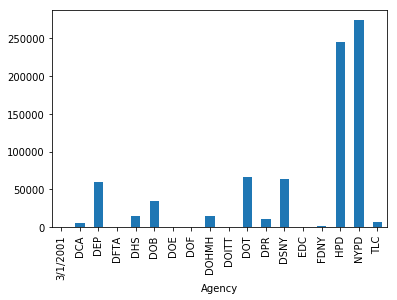

In [9]:
agency_group = data.groupby('Agency')
agency_group.size().plot(kind='bar')

<h2>Let's combine the two in a single graph</h2>


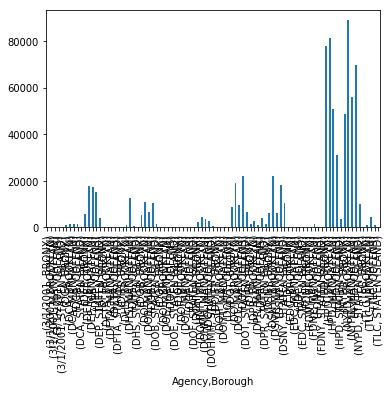

In [10]:
agency_borough = data.groupby(['Agency', 'Borough'])
agency_borough.size().plot(kind='bar')

<h2>This is quite unreadable and pointless!</h2>

<h3>We can unstack the groups so that we get borough by agency</h3>

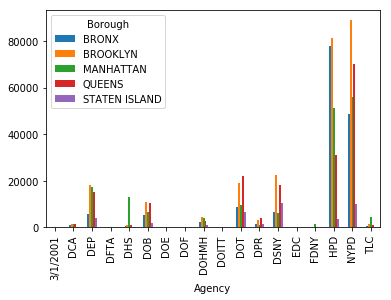

In [11]:
agency_borough.size().unstack().plot(kind='bar')

<h3>Increase the size of the image and add a title</h3>

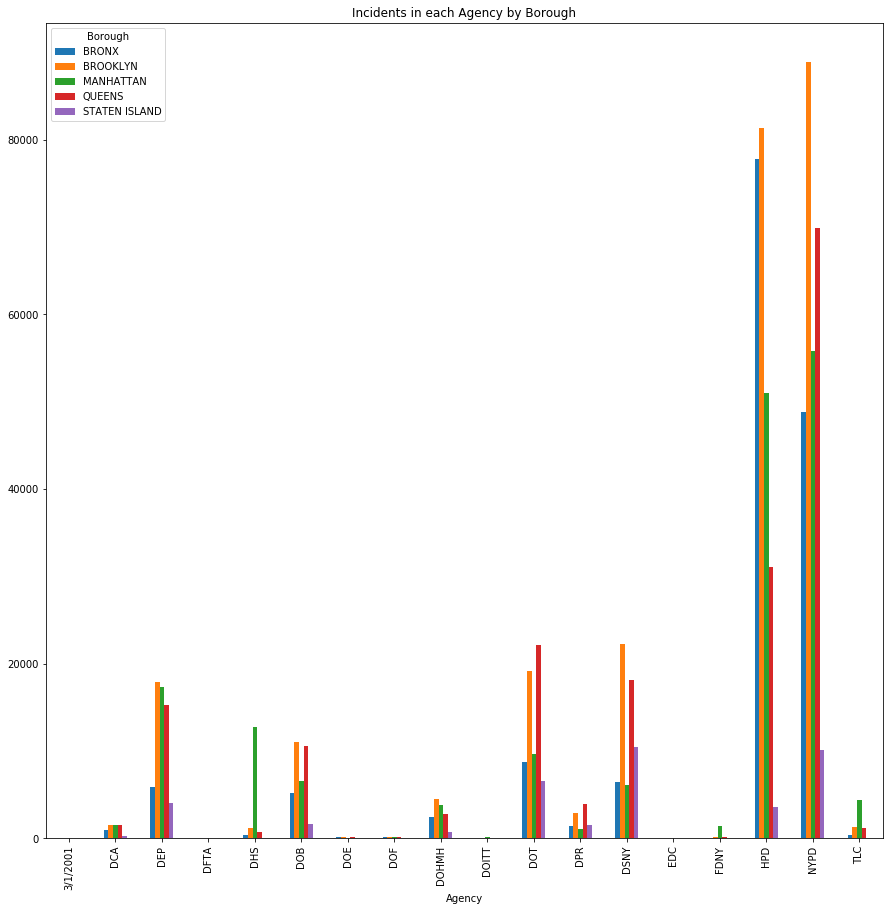

In [12]:
agency_borough = data.groupby(['Agency', 'Borough'])
agency_borough.size().unstack().plot(kind='bar', title="Incidents in each Agency by Borough", figsize=(15,15))

<h1>Digression: The pandas groupby function</h1>

<h4>You can use functions to group data</h4>

In [13]:
import pandas as pd
writers = pd.DataFrame({'Author': ['George Orwell', 'John Steinbeck',
                                  'Pearl Buck', 'Agatha Christie'],
                        'Country': ['UK', 'USA', 'USA', 'UK'],
                        'Gender': ['M', 'M', 'F', 'F'],
                        'Age': [46, 66, 80, 85]})

In [14]:
writers

,Author,Country,Gender,Age
0,George Orwell,UK,M,46
1,John Steinbeck,USA,M,66
2,Pearl Buck,USA,F,80
3,Agatha Christie,UK,F,85


<h4>Group by country</h4>

In [15]:
grouped = writers.groupby('Country')
grouped.first()
#grouped.last()
#grouped.sum()
#grouped.mean()
#grouped.apply(sum)

,Author,Gender,Age
Country,,,
UK,George Orwell,M,46
USA,John Steinbeck,M,66


In [16]:
grouped.groups

{'UK': Int64Index([0, 3], dtype='int64'),
 'USA': Int64Index([1, 2], dtype='int64')}

<h4>Group by multiple columns</h4>

In [17]:
grouped = writers.groupby(['Country','Gender'])
grouped.groups

{('UK', 'F'): Int64Index([3], dtype='int64'),
 ('UK', 'M'): Int64Index([0], dtype='int64'),
 ('USA', 'F'): Int64Index([2], dtype='int64'),
 ('USA', 'M'): Int64Index([1], dtype='int64')}

<h4>Group by age groups</h4>

In [18]:
def age_groups(df, index, col):
    print(index, col)
    if df[col].iloc[index] < 30:
        return 'Young'
    if df[col].iloc[index] < 60:
        return 'Middle'
    else:
        return 'Old'

In [19]:
writers['Age'].iloc[0]

46

In [20]:
grouped = writers.groupby(lambda x: age_groups(writers, x, 'Age'))
grouped.groups

0 Age
1 Age
2 Age
3 Age


{'Middle': Int64Index([0], dtype='int64'),
 'Old': Int64Index([1, 2, 3], dtype='int64')}

<h2>Grouping by the values in a column</h2>
<h3>For example, grouping the data by values in a column that are greater than or less than zero</h3>

In [21]:
import numpy as np 

In [22]:
people = pd.DataFrame(np.random.randn(5, 5), columns=['a', 'b', 'c', 'd', 'e'], index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people

,a,b,c,d,e
Joe,0.573523,1.883055,-1.659332,0.268459,0.346315
Steve,0.032727,0.164186,0.275743,0.749546,0.033980
Wes,0.001678,-1.701033,-0.313408,0.164076,0.109513
Jim,1.145498,0.745924,0.480623,2.155942,0.447812
Travis,-0.368951,-1.337728,0.428260,0.101982,0.526672


<h3>Write a function that takes three arguments - a dataframe, an index, and a column name and returns the grouping for that row</h3>

In [24]:
def GroupColFunc(df, ind, col):
    if df[col].loc[ind] > 0:
        return 'Group1'
    else:
        return 'Group2'

In [25]:
people.groupby(lambda x: GroupColFunc(people, x, 'a')).groups

{'Group1': Index(['Joe', 'Steve', 'Wes', 'Jim'], dtype='object'),
 'Group2': Index(['Travis'], dtype='object')}

<h2>Now we can compute stats on these groups</h2>

In [26]:
print(people.groupby(lambda x: GroupColFunc(people, x, 'a')).mean())
print(people.groupby(lambda x: GroupColFunc(people, x, 'a')).std())

               a         b         c         d         e
Group1  0.438357  0.273033 -0.304093  0.834506  0.234405
Group2 -0.368951 -1.337728  0.428260  0.101982  0.526672
               a         b         c         d         e
Group1  0.539612  1.497173  0.964149  0.917115  0.194794
Group2       NaN       NaN       NaN       NaN       NaN


<h1>Incidents by time</h1>
<p>We know the creation date of each incident so we can build a bar graph of number of incidents by month
<p>Not particularly useful with a few months data but if we had all data from 2010, we could use this sort of
analysis to eyeball trends and seasonality
<p>We're going to need to do some data manipulation for this

<h3>We'll start by creating a new date field yyyymm

In [27]:
import datetime
data['yyyymm'] = data['Created Date'].apply(lambda x: datetime.datetime.strftime(x, '%Y%m'))

In [28]:
data['yyyymm']

Unique Key
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
      ...  
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
Name: yyyymm, Length: 799325, dtype: object

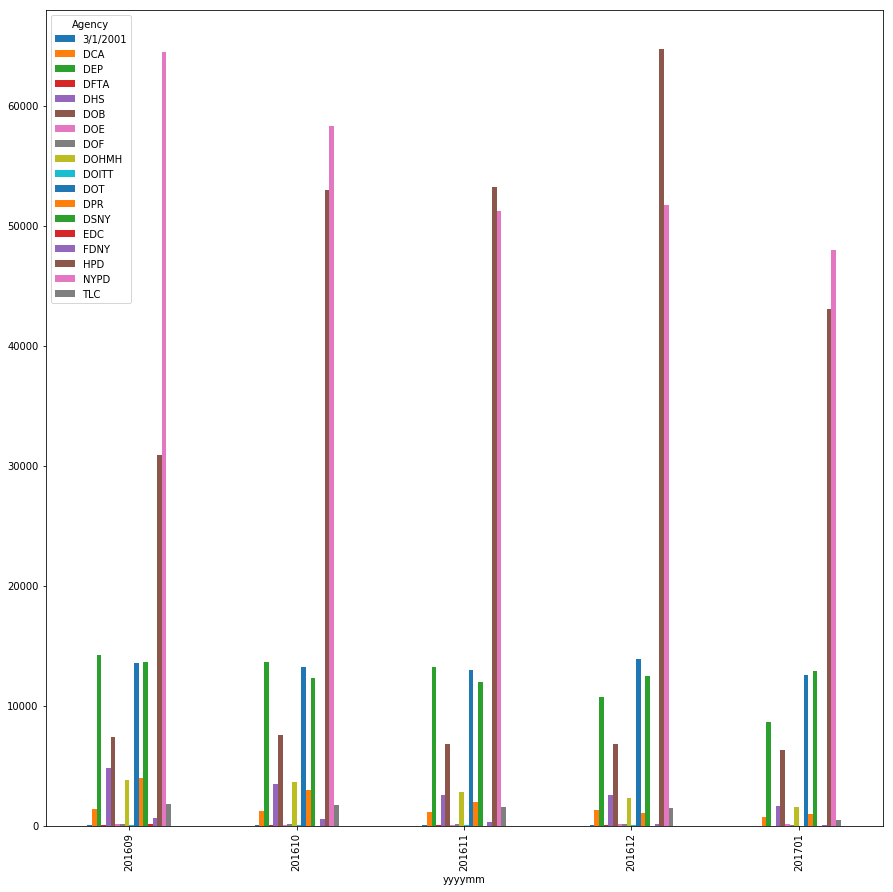

In [29]:
date_agency = data.groupby(['yyyymm', 'Agency'])
date_agency.size().unstack().plot(kind='bar', figsize=(15,15))

<h1>Examining agencies</h1>

<h2>We'll look at the frequency by agency and report the top 5 values</h2>

In [30]:
data.groupby('Agency').size().sort_values(ascending=False)

Agency
NYPD        273683
HPD         244815
DOT          66180
DSNY         63321
DEP          60346
DOB          34821
DHS          15083
DOHMH        14188
DPR          10830
TLC           7129
DCA           5760
FDNY          1676
DOF            579
DOE            454
DOITT          134
EDC            123
3/1/2001       102
DFTA           101
dtype: int64

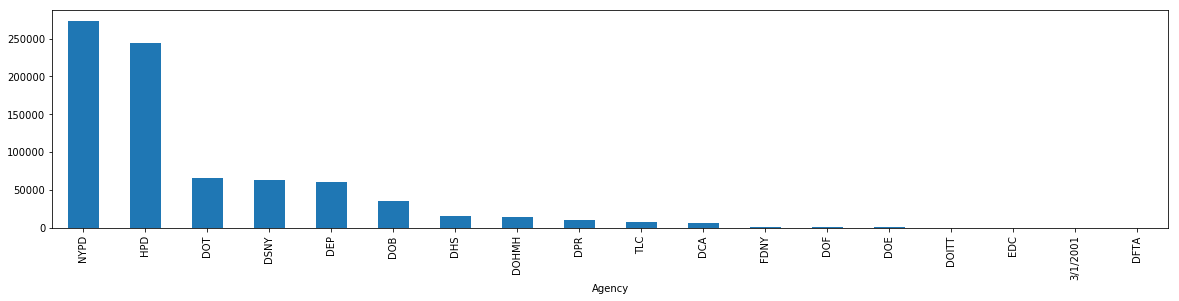

In [31]:
data.groupby('Agency').size().sort_values(ascending=False).plot(kind='bar', figsize=(20,4))

<h3>We can drill down into complaints by Agency by borough</h3>

In [31]:
agency_borough = data.groupby(['Agency', 'Borough']).size().unstack()

In [32]:
agency_borough

Borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
Agency,,,,,
3/1/2001,17.0,28.0,23.0,28.0,6.0
DCA,958.0,1532.0,1529.0,1547.0,194.0
DEP,5837.0,17917.0,17315.0,15216.0,4061.0
DFTA,21.0,33.0,24.0,21.0,2.0
DHS,397.0,1130.0,12767.0,734.0,55.0
DOB,5160.0,10993.0,6507.0,10567.0,1594.0
DOE,129.0,127.0,49.0,136.0,13.0
DOF,143.0,161.0,153.0,112.0,10.0
DOHMH,2406.0,4481.0,3759.0,2814.0,728.0


<h3>We can create 'top 5 Agency' subplots subplots for each borough</h3>

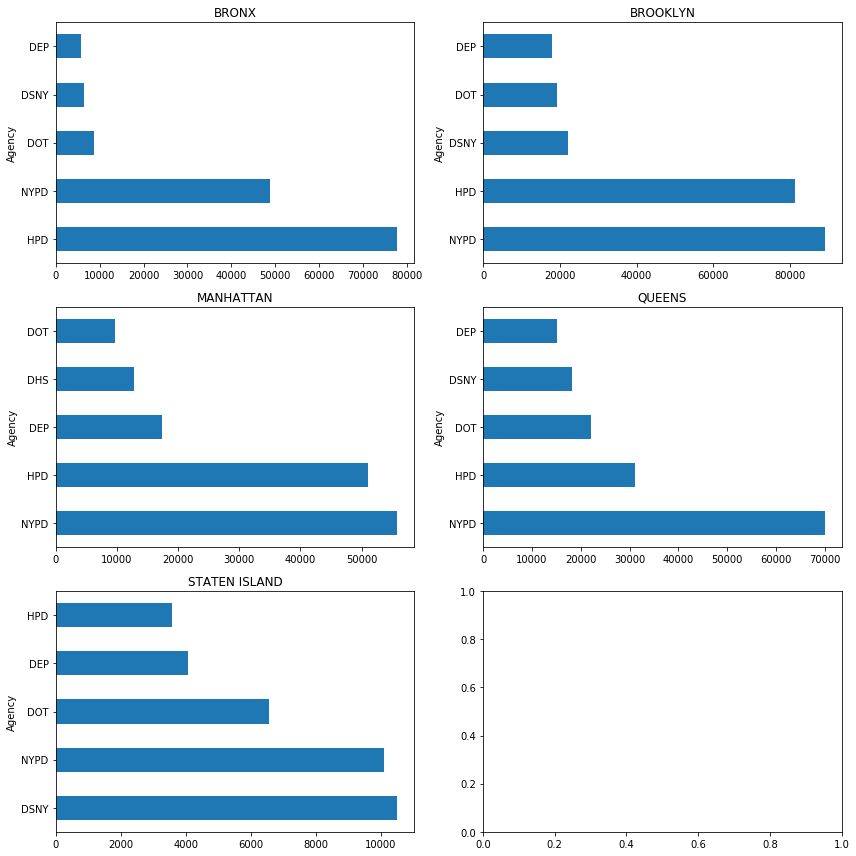

In [33]:
#We'll arrange the subplots in two rows and three columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 2
ROW_NUM = 3
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i, (label, col) in enumerate(agency_borough.iteritems()): 
    ax = axes[int(i / COL_NUM), i % COL_NUM]
    col = col.sort_values(ascending=False)[:5] 
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)

plt.tight_layout() 

In [34]:
for i, (label, col) in enumerate(agency_borough.iteritems()): 
    print(i, label, col)

0 BRONX Agency
3/1/2001       17.0
DCA           958.0
DEP          5837.0
DFTA           21.0
DHS           397.0
DOB          5160.0
DOE           129.0
DOF           143.0
DOHMH        2406.0
DOITT           7.0
DOT          8683.0
DPR          1416.0
DSNY         6406.0
EDC             1.0
FDNY           39.0
HPD         77774.0
NYPD        48837.0
TLC           318.0
Name: BRONX, dtype: float64
1 BROOKLYN Agency
3/1/2001       28.0
DCA          1532.0
DEP         17917.0
DFTA           33.0
DHS          1130.0
DOB         10993.0
DOE           127.0
DOF           161.0
DOHMH        4481.0
DOITT          18.0
DOT         19177.0
DPR          2929.0
DSNY        22208.0
EDC            62.0
FDNY          127.0
HPD         81382.0
NYPD        88973.0
TLC          1238.0
Name: BROOKLYN, dtype: float64
2 MANHATTAN Agency
3/1/2001       23.0
DCA          1529.0
DEP         17315.0
DFTA           24.0
DHS         12767.0
DOB          6507.0
DOE            49.0
DOF           153.0
DOHMH    

<h1>Processing time</h1>
<h2>We can compute simple statistics on processing time</h2>

In [35]:
grouped = data[['processing_time','Borough']].groupby('Borough')

In [36]:
grouped.describe()

processing_time                          \
                        count                    mean   
Borough                                                 
BRONX                  158549  5 days 11:22:37.719443   
BROOKLYN               252516  5 days 01:22:08.215083   
MANHATTAN              171708  5 days 07:43:59.892724   
QUEENS                 177641  4 days 22:17:48.580001   
STATEN ISLAND           38911  5 days 00:57:18.272467   

                                                                          \
                                   std              min              25%   
Borough                                                                    
BRONX          10 days 19:29:44.182314  0 days 00:00:00  0 days 05:49:00   
BROOKLYN       11 days 20:44:39.307668  0 days 00:00:00  0 days 02:33:00   
MANHATTAN      12 days 01:57:04.429904  0 days 00:00:00  0 days 02:04:00   
QUEENS         13 days 02:00:33.811201  0 days 00:00:00  0 days 02:08:00   
STATEN ISLAND  12 days 00:18:50.605702  0 days 00:00:00  0 days 02:54:00   

                                                                    
                           50%              75%                max  
Borough                                                             
BRONX          1 days 21:27:00  5 days 19:48:00  145 days 00:24:00  
BROOKLYN       0 days 20:19:00  4 days 05:20:00  146 days 17:27:00  
MANHATTAN      0 days 22:13:00  4 days 11:06:00  139 days 22:42:00  
QUEENS         0 days 10:15:00  3 days 20:47:00  148 days 13:11:00  
STATEN ISLAND  0 days 22:11:00  4 days 15:24:30  139 days 22:06:00

<h3>But it is easier to convert the timedelta processing_time into floats for calculation purposes</h3>

In [37]:
import numpy as np
#The time it takes to process. Cleaned up
data['float_time'] =data['processing_time'].apply(lambda x: x / np.timedelta64(1, 'D'))

In [38]:
data

,Created Date,Closed Date,Agency,Incident Zip,Borough,Latitude,Longitude,processing_time,yyyymm,float_time
Unique Key,,,,,,,,,,
1,2016-09-01 00:33:00,2016-09-16 01:06:00,DCA,10001,MANHATTAN,40.744790,-73.988834,15 days 00:33:00,201609,15.022917
1,2016-09-01 20:16:00,2016-09-10 18:08:00,HPD,11691,QUEENS,40.600554,-73.750704,8 days 21:52:00,201609,8.911111
1,2016-09-01 12:17:00,2016-09-07 12:00:00,DSNY,11211,BROOKLYN,40.704925,-73.962007,5 days 23:43:00,201609,5.988194
1,2016-09-01 12:10:00,2016-09-10 14:23:00,HPD,10027,MANHATTAN,40.812322,-73.955338,9 days 02:13:00,201609,9.092361
1,2016-09-01 12:32:00,2016-09-11 02:03:00,HPD,10452,BRONX,40.839529,-73.922534,9 days 13:31:00,201609,9.563194
1,2016-09-01 20:16:00,2016-09-10 18:08:00,HPD,11691,QUEENS,40.600554,-73.750704,8 days 21:52:00,201609,8.911111
1,2016-09-01 08:35:00,2016-09-07 12:00:00,DSNY,11428,QUEENS,40.721866,-73.745982,6 days 03:25:00,201609,6.142361
1,2016-09-01 13:19:00,2016-09-16 14:32:00,DOT,11101,QUEENS,40.746875,-73.952711,15 days 01:13:00,201609,15.050694
1,2016-09-01 11:00:00,2016-09-08 12:00:00,DSNY,10075,MANHATTAN,40.773336,-73.955054,7 days 01:00:00,201609,7.041667


<h2>Now we can compute stats easily</h2>

In [39]:
grouped = data[['float_time', 'Agency']].groupby('Agency')
grouped.mean().sort_values('float_time', ascending=False)

,float_time
Agency,
EDC,49.604031
FDNY,32.995218
DPR,24.395774
TLC,24.196719
DOITT,18.300145
DOHMH,15.897532
DOB,12.345866
DOE,11.360773
DCA,9.254593


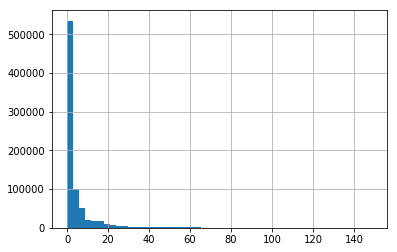

In [40]:
data['float_time'].hist(bins=50)

<h1>Other useful visualization libraries</h1>
<h2>seaborn: https://seaborn.pydata.org/</h2>
<h2>bokeh: http://bokeh.pydata.org/en/latest/</h2>
<h2>plotly: https://plot.ly/</h2>
